# RNN Model:
Micro to-do:
- Don't drop 'week'

To do:
- Widowing function using pytorch
    - might face some issues since index is the same week. Do groupby weeks?
- Build a RNN LSTM using pytorch or tensor
- Evaluation matrics
- save the model
- ref: https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/
- https://www.youtube.com/watch?v=tepxdcepTbY

In [1]:
# Import packages
import pandas as pd
import os
import numpy as np 
import warnings
import IPython
import IPython.display

import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

c:\Users\myeng\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
import pandas as pd 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

def run_datapipeline():
    """Data preprocessing pipeline

    Args:
        data_path1,data_path2,data_path3
    """
    df1 = pd.read_csv('./data/train_GzS76OK/train.csv') #'./data/train_GzS76OK/train.csv'
    df2 = pd.read_csv('./data/train_GzS76OK/fulfilment_center_info.csv') #'./data/train_GzS76OK/fulfilment_center_info.csv'
    df3 = pd.read_csv('./data/train_GzS76OK/meal_info.csv') # './data/train_GzS76OK/meal_info.csv'

    # 1. Merge all df 
    df = pd.merge(df1, df2, on='center_id',how='left')
    df = pd.merge(df,df3,on='meal_id',how='left')

    # convert weeks to time stamp
    # Calculate the date corresponding to the start of the first week
    start_date = pd.to_datetime('2019-01-28')

    # Calculate the date for each week based on the start date and the week number
    df['date'] = start_date + pd.to_timedelta(df['week'] - 1, unit='W')

    # Set the 'date' column as the index of the DataFrame
    df.set_index('date', inplace=True)

    # 2. add a add_price_adjustment column
    # df['add_price_adjustment'] = df ['checkout_price'] - df ['base_price']

    # category and cuisine very similar. Hence, combine them.
    df['category-cuisine'] = df['category'] +'-'+ df['cuisine'] 

    # Split train and test first
    train_length = df['week'].nunique()*0.8 #80% train
    df_train = df.loc[df['week'] <= train_length] #week range from 1 to 116
    df_test = df.loc[df['week'] > train_length] #week range from 117 to 145

    # 3. Drop unless columns
    df_train.drop(['id', 'cuisine','category'], axis = 1, inplace =True) #checkout price and week are kept
    df_test.drop(['id', 'cuisine','category'], axis = 1, inplace =True)

    #4.Split data into cat and num data for one-hot and standardscalar for df_train
    one_hot_list = ['center_type','category-cuisine']
    normalize_list = ['base_price', 'add_price_adjustment']

    ohe_transformer = OneHotEncoder()
    df_encoded_train = ohe_transformer.fit_transform(df_train[one_hot_list]).toarray()
    df_encoded_df_train = pd.DataFrame(df_encoded_train, columns=ohe_transformer.get_feature_names_out(one_hot_list),index=df_train.index)

    df_encoded_test = ohe_transformer.fit_transform(df_test[one_hot_list]).toarray()
    df_encoded_df_test = pd.DataFrame(df_encoded_test, columns=ohe_transformer.get_feature_names_out(one_hot_list),index=df_test.index)

    # Concatenate the original dataframe and the encoded dataframe
    df_train = pd.concat([df_train, df_encoded_df_train], axis=1)
    df_train.drop(one_hot_list, axis = 1, inplace =True)

    df_test = pd.concat([df_test, df_encoded_df_test], axis=1)
    df_test.drop(one_hot_list, axis = 1, inplace =True)

    # # 4.num data for standard scaler
    # num_transformer = StandardScaler()

    # # transform the selected columns
    # scaled_columns = num_transformer.fit_transform(df_train[normalize_list])

    # # create a new DataFrame with the scaled columns
    # df_train[normalize_list] = scaled_columns

    return df_train , df_test

In [42]:
# to use the datapipeline.py:
# from src.datapipeline import run_datapipeline

# note that I kept 'week' here for downsampling so i can train my model faster.
# I also did not use standard scaler as I will normlize again for RNN
# df['add_price_adjustment'] = df ['checkout_price'] - df ['base_price'] removed. To be added later

df_train, df_test = run_datapipeline()
print (df_train.shape)
print (df_test.shape)

C:\Users\myeng\AppData\Local\Temp\ipykernel_20916\2865273012.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['id', 'cuisine','category'], axis = 1, inplace =True) #checkout price and week are kept
C:\Users\myeng\AppData\Local\Temp\ipykernel_20916\2865273012.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['id', 'cuisine','category'], axis = 1, inplace =True)


(361348, 33)
(95200, 33)


In [35]:
# add back the week column

# df_train['week'] = df_train.index.weekofyear
# df_test['week'] = df_train.index.weekofyear

In [9]:
# A way to just extract a df of specifc value in a column
# mask = df_train['center_id'] == 66
# new_df = df_train[mask]
# new_df.shape

(4811, 33)

In [3]:
df_train.columns

Index(['week', 'center_id', 'meal_id', 'base_price', 'emailer_for_promotion',
       'homepage_featured', 'num_orders', 'Unnamed: 9', 'Unnamed: 10',
       'city_code', 'region_code', 'op_area', 'add_price_adjustment',
       'center_type_TYPE_A', 'center_type_TYPE_B', 'center_type_TYPE_C',
       'category-cuisine_Beverages-Continental',
       'category-cuisine_Beverages-Indian',
       'category-cuisine_Beverages-Italian', 'category-cuisine_Beverages-Thai',
       'category-cuisine_Biryani-Indian', 'category-cuisine_Desert-Indian',
       'category-cuisine_Extras-Thai', 'category-cuisine_Fish-Continental',
       'category-cuisine_Other Snacks-Thai', 'category-cuisine_Pasta-Italian',
       'category-cuisine_Pizza-Continental',
       'category-cuisine_Rice Bowl-Indian', 'category-cuisine_Salad-Italian',
       'category-cuisine_Sandwich-Italian',
       'category-cuisine_Seafood-Continental', 'category-cuisine_Soup-Thai',
       'category-cuisine_Starters-Thai'],
      dtype='objec

In [43]:
df_train = df_train.drop(['Unnamed: 9', 'Unnamed: 10'], axis=1)
df_test = df_test.drop(['Unnamed: 9', 'Unnamed: 10'], axis=1)

In [44]:
print (df_train.shape)
print (df_test.shape)

(361348, 31)
(95200, 31)


In [26]:
print(df_test.index.unique())

DatetimeIndex(['2021-04-19', '2021-04-26', '2021-05-03', '2021-05-10',
               '2021-05-17', '2021-05-24', '2021-05-31', '2021-06-07',
               '2021-06-14', '2021-06-21', '2021-06-28', '2021-07-05',
               '2021-07-12', '2021-07-19', '2021-07-26', '2021-08-02',
               '2021-08-09', '2021-08-16', '2021-08-23', '2021-08-30',
               '2021-09-06', '2021-09-13', '2021-09-20', '2021-09-27',
               '2021-10-04', '2021-10-11', '2021-10-18', '2021-10-25',
               '2021-11-01'],
              dtype='datetime64[ns]', name='date', freq=None)


In [27]:
print(df_train.index.unique())

DatetimeIndex(['2019-01-28', '2019-02-04', '2019-02-11', '2019-02-18',
               '2019-02-25', '2019-03-04', '2019-03-11', '2019-03-18',
               '2019-03-25', '2019-04-01',
               ...
               '2021-02-08', '2021-02-15', '2021-02-22', '2021-03-01',
               '2021-03-08', '2021-03-15', '2021-03-22', '2021-03-29',
               '2021-04-05', '2021-04-12'],
              dtype='datetime64[ns]', name='date', length=116, freq=None)


### For RNN model training: Get the raw table and keep only the base_price, add_price_adjustment, num_orders

- I group by sum as I want to forecast the total number of orders (demand) for the next 10 weeks 
- aim: get univariate RNN first

In [45]:
# Merge both df first
# combine the two dataframes
df = pd.concat([df_train, df_test], axis=0)

# keep only the base_price, add_price_adjustment and num_orders
df_RNN = df.loc[:,['week', 'base_price' , 'checkout_price', 'num_orders']]

# group by the 'week' column and mean the other columns
df_RNN = df_RNN.groupby('week').sum()

In [46]:
df_RNN

,base_price,checkout_price,num_orders
week,,,
1,1018365.32,965809.26,792261
2,1005779.20,938092.43,787084
3,1008352.05,948560.28,695262
4,1006446.90,953833.69,743529
5,1001075.16,901141.58,1198675
...,...,...,...
141,1168541.44,1133461.40,776240
142,1156108.41,1124552.90,739661
143,1193624.73,1131454.15,759926


In [47]:
# Add back add_price_adjustment and remove checkout_price
df_RNN['add_price_adjustment'] = df_RNN ['checkout_price'] - df_RNN ['base_price']
df_RNN = df_RNN.drop(['checkout_price'], axis=1)
df_RNN

,base_price,num_orders,add_price_adjustment
week,,,
1,1018365.32,792261,-52556.06
2,1005779.20,787084,-67686.77
3,1008352.05,695262,-59791.77
4,1006446.90,743529,-52613.21
5,1001075.16,1198675,-99933.58
...,...,...,...
141,1168541.44,776240,-35080.04
142,1156108.41,739661,-31555.51
143,1193624.73,759926,-62170.58


(116, 3)
(29, 3)


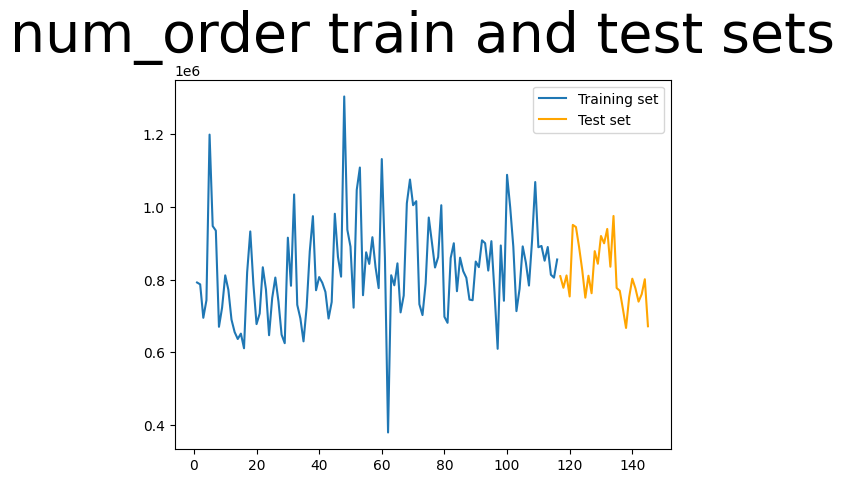

In [64]:
# downsample for the script to run faster:

# df_train = df_train.loc[df_train.index >= '2021-02-08'] #week 106 to 116
# df_test = df_test.loc[df_test.index <= '2021-05-03'] #week 117 to 119


df_train = df_RNN.loc[df_RNN.index <= 116] # Train on 116 weeks past data. (80%)
df_test = df_RNN.loc[df_RNN.index > 116] # 29 weeks in advance (to 145 week) (20%)

plt.title('num_order train and test sets', size=40)
plt.plot(df_train['num_orders'], label='Training set')
plt.plot(df_test['num_orders'], label='Test set', color='orange')
plt.legend()

print (df_train.shape)
print (df_test.shape)

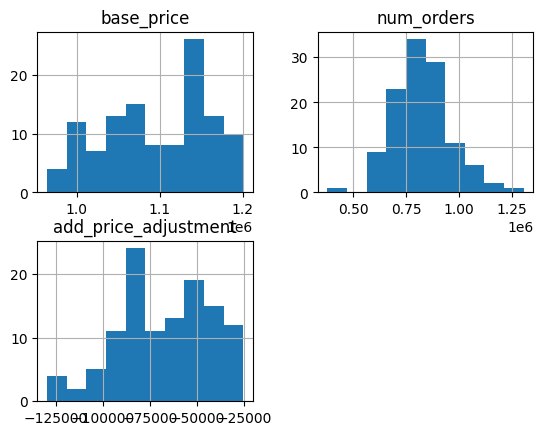

In [65]:
# see the distribution of each columns
# assume we have a dataframe named "df"
df_train.hist()
plt.show()

StandardScalar for the features.

C:\Users\myeng\AppData\Local\Temp\ipykernel_20916\3164434877.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[normalize_list] = scaled_columns


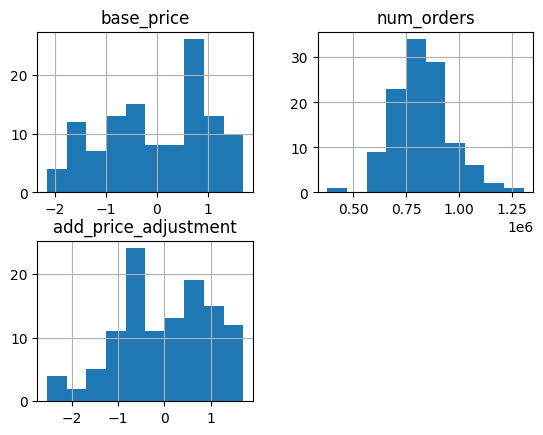

In [66]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
X_scaler  = StandardScaler()
# X_scaler_1 = MinMaxScaler()

normalize_list = ['base_price', 'add_price_adjustment']

scaled_columns = X_scaler.fit_transform(df_train[normalize_list])

df_train[normalize_list] = scaled_columns

df_train.hist()
plt.show()

One way to predict 1 week in advance is customize the sliding window. eg. n_past = len(df['week'] == 1)

In [8]:
# Group by week
# df_train = df_train.groupby(level=0, group_keys=True).apply(lambda x: x)

create input and output sequences using a rolling window approach:

Note: (can try if got time)
- For this down sampled data, I have trian fo week 106 to 116. For test is have week 117 to 119.
- So for rolling window (eg. lookback = 10 week, lookahead = 3 weeks)
- Get a new df with only the weeks. Create a list of the value_counts of each weeks in both test and train. Use the list for lookback and lookahead. 

To do:
- Feature select only check out price and adjusted price. Target is number orders
- Group by weeks, and group by sum of the 3 columns.
- Aim is to see how the prices affect the num_orders.

In [ ]:
# split the week into another df 


In [ ]:
# Getting the total number of lookback and lookahead

# list_of_weeks_train = [106,107,108,109,110,111,112,113,114,115,116]
# list_of_weeks_test = [117,118,119]
# lookback= 


#### Prepare the data for RNN model for univariate (only target data)
- Scaling and Windowing
- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [311]:
# to use the datapipeline.py:
# from src.datapipeline import run_datapipeline

# note that I kept 'week' here for downsampling so i can train my model faster.
# I also did not use standard scaler as I will normlize again for RNN
# df['add_price_adjustment'] = df ['checkout_price'] - df ['base_price'] removed. To be added later

np.random.seed(0)
torch.manual_seed(0)

df_train, df_test = run_datapipeline()
print (df_train.shape)
print (df_test.shape)

# Merge both df first
# combine the two dataframes
df = pd.concat([df_train, df_test], axis=0)

# keep only the base_price, add_price_adjustment and num_orders
df_RNN = df.loc[:,['week', 'base_price' , 'checkout_price', 'num_orders']]

# group by the 'week' column and mean the other columns
df_RNN = df_RNN.groupby('week').sum()

# Add back add_price_adjustment and remove checkout_price
df_RNN['add_price_adjustment'] = df_RNN ['checkout_price'] - df_RNN ['base_price']
df_RNN = df_RNN.drop(['checkout_price'], axis=1)
df_RNN

C:\Users\myeng\AppData\Local\Temp\ipykernel_20916\2865273012.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(['id', 'cuisine','category'], axis = 1, inplace =True) #checkout price and week are kept
C:\Users\myeng\AppData\Local\Temp\ipykernel_20916\2865273012.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.drop(['id', 'cuisine','category'], axis = 1, inplace =True)


(361348, 33)
(95200, 33)


,base_price,num_orders,add_price_adjustment
week,,,
1,1018365.32,792261,-52556.06
2,1005779.20,787084,-67686.77
3,1008352.05,695262,-59791.77
4,1006446.90,743529,-52613.21
5,1001075.16,1198675,-99933.58
...,...,...,...
141,1168541.44,776240,-35080.04
142,1156108.41,739661,-31555.51
143,1193624.73,759926,-62170.58


In [312]:
# Get only the target
df_uni_RNN = pd.DataFrame(df_RNN ['num_orders'])
df_uni_RNN

,num_orders
week,
1,792261
2,787084
3,695262
4,743529
5,1198675
...,...
141,776240
142,739661
143,759926


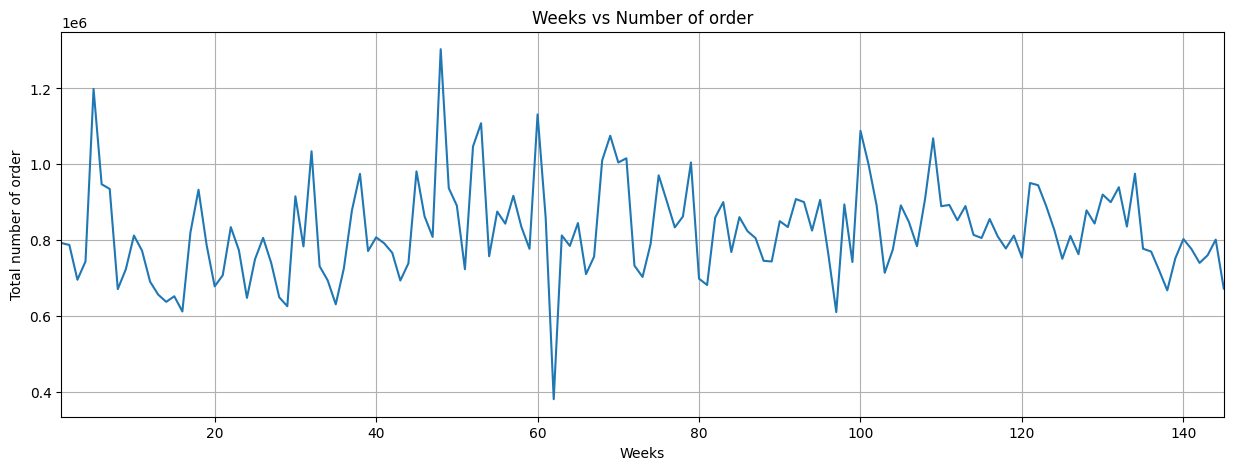

In [114]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size

plt.title('Weeks vs Number of order')
plt.ylabel('Total number of order')
plt.xlabel('Weeks')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(df_uni_RNN['num_orders'])

(116, 1)
(29, 1)


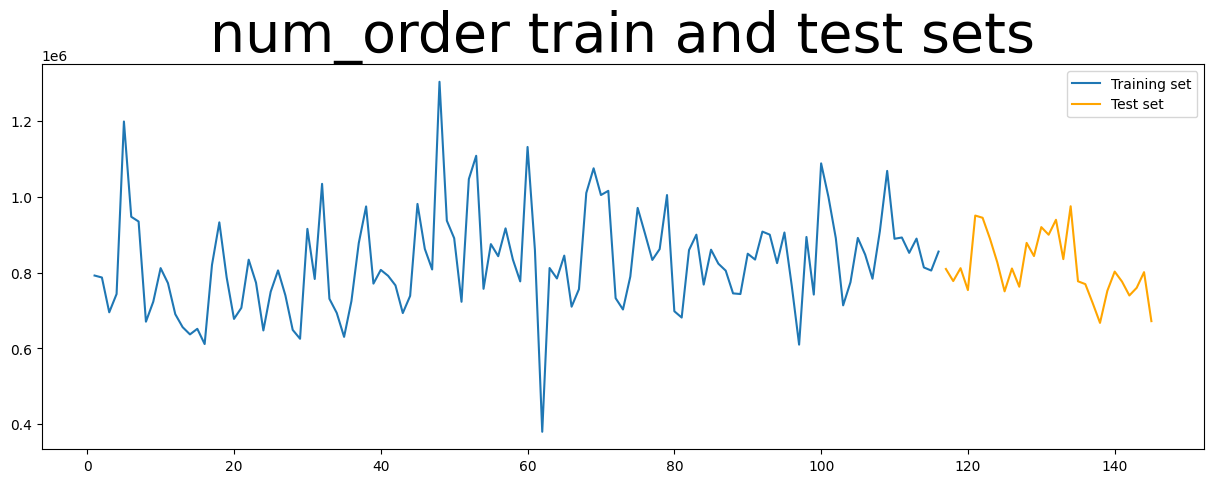

In [313]:
# train-test split for time series
train_size = int(len(df_uni_RNN) * 0.8) #116 weeks for training
test_size = len(df_uni_RNN) - train_size #29 weeks for testing
train, test = df_uni_RNN[:train_size], df_uni_RNN[train_size:]

plt.title('num_order train and test sets', size=40)
plt.plot(train['num_orders'], label='Training set')
plt.plot(test['num_orders'], label='Test set', color='orange')
plt.legend()

print (train.shape)
print (test.shape)

In [314]:
# Can consider scaling it
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

Usually time series prediction is done on a window. That is, given data from time to time , you are asked to predict for time (or deeper into the future). The size of window governs how much data you are allowed to look at when you make the prediction. This is also called the look back period.

On a long enough time series, multiple overlapping window can be created. It is convenient to create a function to generate a dataset of fixed window from a time series. Since the data is going to be used in a PyTorch model, the output dataset should be in PyTorch tensors:

In [105]:
# def create_dataset(dataset, lookback):
#     """Transform a time series into a prediction dataset
    
#     Args:
#         dataset: A numpy array of time series, first dimension is the time steps
#         lookback: Size of window for prediction
#     """
#     X, y = [], []
#     for i in range(len(dataset)-lookback):
#         feature = dataset[i:i+lookback]
#         target = dataset[i+1:i+lookback+1]
#         X.append(feature)
#         y.append(target)
#     return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

In [315]:
def create_dataset(dataset, lookback, lookforward, shift):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
        lookforward: Number of time steps to predict into the future
        shift: Number of time steps to shift the target
    """
    X, y = [], []
    for i in range(len(dataset)-lookback-lookforward+1):
        feature = dataset[i:i+lookback]
        target = dataset[i+lookforward:i+lookforward+shift]
        X.append(feature)
        y.append(target)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

 the dataset argument is assumed to be a numpy array where the first dimension represents the time steps and the remaining dimensions represent the different features in the time series. The lookback argument specifies the number of time steps to include in the input feature window, and lookforward specifies the number of time steps to predict into the future. The shift argument specifies the number of time steps to shift the target relative to the last time step in the input feature window. The X and y lists are constructed by iterating over the time steps and appending the corresponding input feature window and target to the lists. Finally, the lists are converted to PyTorch tensors and returned.

In [316]:
# Convert the data to a numpy array
# train_np = np.array(train)
# test_np = np.array(test)

lookback = 12 # Look back at 12 weeks 
lookforward = 1 # predict 1 weeks in advance
shift = 1
X_train, y_train = create_dataset(train, lookback=lookback, lookforward = lookforward, shift = shift)
X_test, y_test = create_dataset(test, lookback=lookback, lookforward = lookforward, shift = shift)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([104, 12, 1]) torch.Size([104, 1, 1])
torch.Size([17, 12, 1]) torch.Size([17, 1, 1])


In [317]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

In [318]:
import numpy as np
import torch.optim as optim
import torch.utils.data as data
 
model = LSTM()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
 
n_epochs = 1000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

c:\Users\myeng\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8, 1, 1])) that is different to the input size (torch.Size([8, 12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\myeng\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([104, 1, 1])) that is different to the input size (torch.Size([104, 12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\myeng\anaconda3\envs\torch\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([17, 1, 1])) that is different to the input size (torch.Size([17, 12, 1])). This will likely lead to incorrect results due to broadca

Epoch 0: train RMSE 0.4025, test RMSE 0.4180
Epoch 100: train RMSE 0.1196, test RMSE 0.0725
Epoch 200: train RMSE 0.0712, test RMSE 0.0420
Epoch 300: train RMSE 0.0443, test RMSE 0.0239
Epoch 400: train RMSE 0.0437, test RMSE 0.0246
Epoch 500: train RMSE 0.0424, test RMSE 0.0229
Epoch 600: train RMSE 0.0425, test RMSE 0.0235
Epoch 700: train RMSE 0.0424, test RMSE 0.0234
Epoch 800: train RMSE 0.0423, test RMSE 0.0232
Epoch 900: train RMSE 0.0422, test RMSE 0.0231


In [330]:
train_size+lookback+test_size - train_size

41

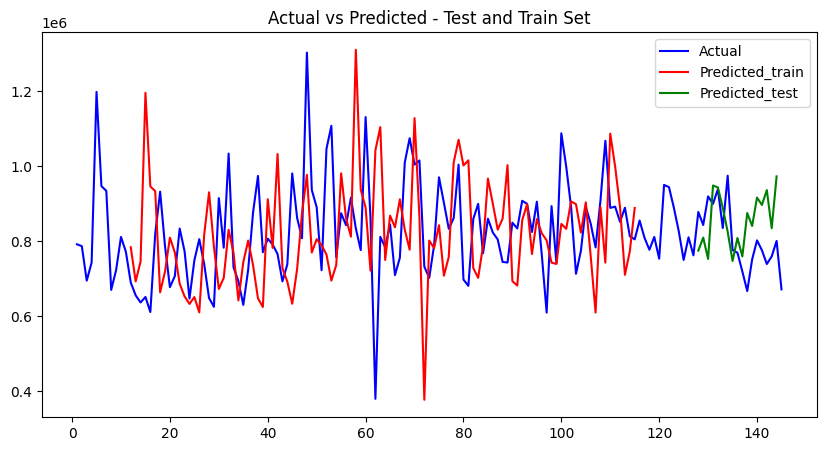

In [337]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(df_uni_RNN) * np.nan
    # y_pred_train = model(X_train)
    # y_pred_train = y_pred[:, -1, :]
    train_plot[lookback:train_size] = scaler.inverse_transform(model(X_train)[:, -1, :]) #12 to 116 weeks 
    # [lookback:train_size]

    # shift test predictions for plotting
    # y_pred_test = model(X_test)
    # y_pred_test = y_pred[:, -1, :]
    test_plot = np.ones_like(df_uni_RNN) * np.nan
    test_plot[train_size+lookback:len(df_uni_RNN)] = scaler.inverse_transform(model(X_test)[:, -1, :]) #116+12 to 145. So it will show week 128 to 145
    # [train_size+lookback:len(df_uni_RNN)]
# plot
plt.figure(figsize=(10, 5))
plt.title('Actual vs Predicted - Test and Train Set')
plt.plot(df_uni_RNN, c='b', label='Actual')
plt.plot(train_plot, c='r', label='Predicted_train')
plt.plot(test_plot, c='g', label='Predicted_test')
plt.legend()
plt.show()

In [299]:
# store the results in df
# Make predictions on the test set
with torch.no_grad():
    y_pred_test = model(X_test)
    y_pred_test = scaler.inverse_transform(y_pred_test[:, -1, :].numpy())

# Make predictions on the training set
with torch.no_grad():
    y_pred_train = model(X_train)
    y_pred_train = scaler.inverse_transform(y_pred_train[:, -1, :].numpy())

# Convert the targets to numpy arrays
y_test = scaler.inverse_transform((y_test.reshape(-1, 1)).numpy())
y_train = scaler.inverse_transform((y_train.reshape(-1, 1)).numpy())

# Create a DataFrame to store the predicted values
pred_df_test = pd.DataFrame({
    'y_pred_test': y_pred_test.flatten(),
    'y_test': y_test.flatten()
})

pred_df_train = pd.DataFrame({
    'y_pred_train': y_pred_train.flatten(),
    'y_train': y_train.flatten()
})

    y_pred_test       y_test
0   775466.1875  777707.0000
1   809349.7500  811708.9375
2   752010.3125  753871.0000
3   950090.6250  950500.0000
4   943866.5000  944706.0000
5   889129.3125  889926.0000
6   826986.6875  827257.0000
7   748873.6250  750541.0000
8   809963.6875  810838.0000
9   760325.8750  762737.0000
10  875893.0625  878397.0000
11  839685.1250  843661.0000
12  915804.7500  920019.0000
13  894695.5000  899953.0000
14  934294.2500  939373.9375
15  829827.8750  835583.0000
16  970795.8750  975072.0000


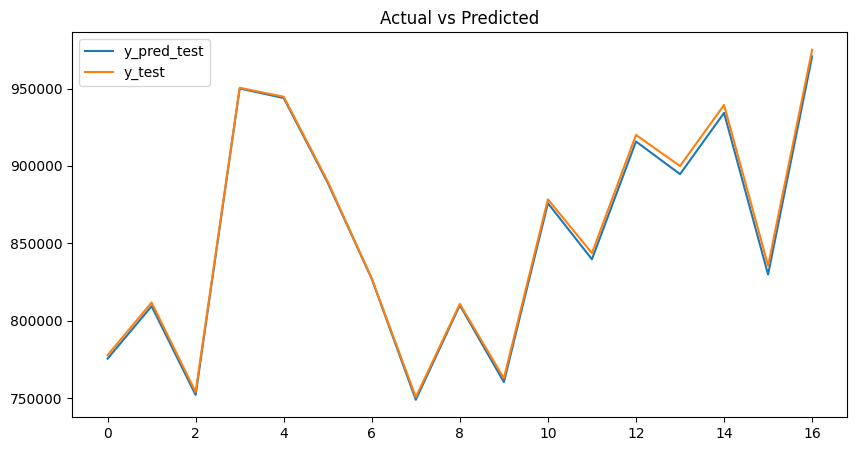

In [290]:
print (pred_df_test) #predict 17 weeks in advance

pred_df_test.plot(figsize=(10, 5))
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

     y_pred_train       y_train
0    7.825334e+05  7.870840e+05
1    6.913279e+05  6.952619e+05
2    7.394699e+05  7.435290e+05
3    1.192263e+06  1.198675e+06
4    9.348388e+05  9.472879e+05
..            ...           ...
99   9.987891e+05  9.994470e+05
100  8.901642e+05  8.909830e+05
101  7.118665e+05  7.135689e+05
102  7.740498e+05  7.746440e+05
103  8.913545e+05  8.914790e+05

[104 rows x 2 columns]


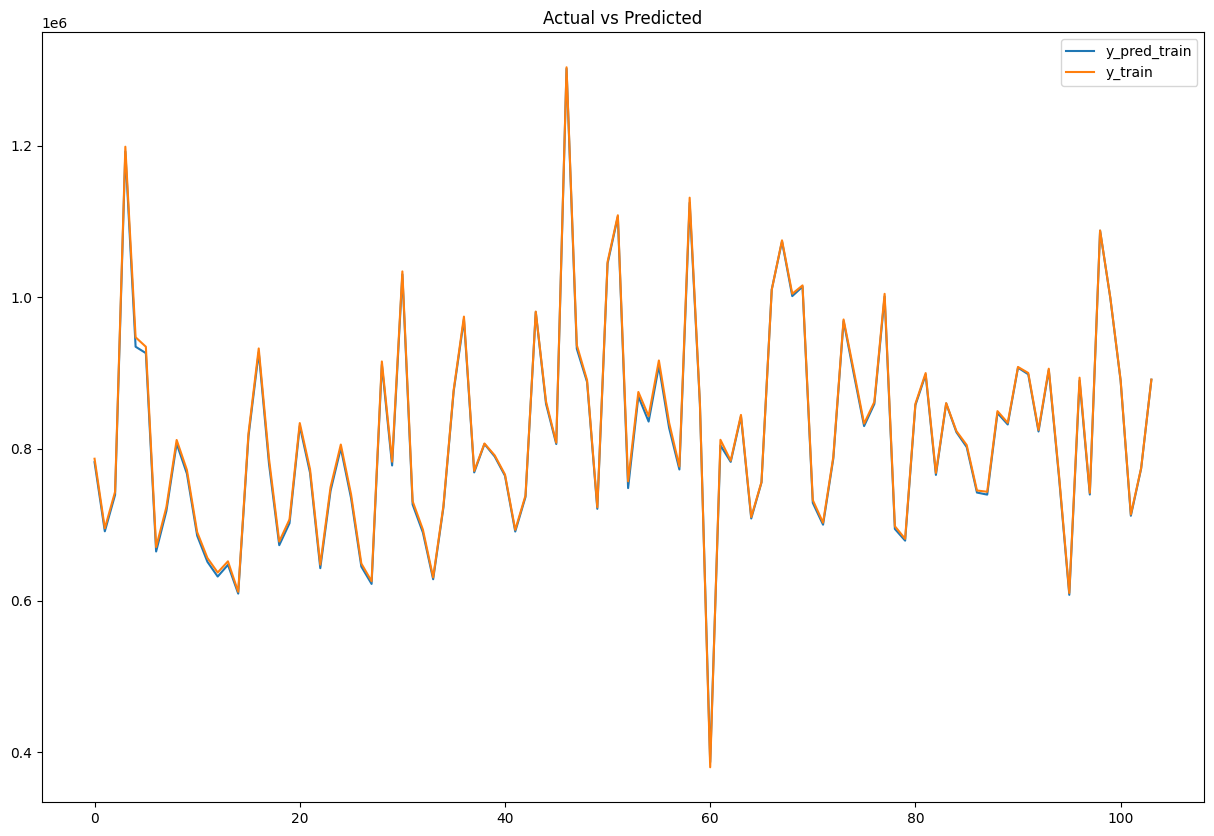

In [301]:
print (pred_df_train) #predict 17 weeks in advance

pred_df_train.plot(figsize=(15, 10))
plt.title("Actual vs Predicted")
plt.legend()
plt.show()

Create a Class here:

Create A multivariant RNN model

In [ ]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
     X = []
     y = []
     start = start + window
     if end is None:
         end = len(dataset) - horizon
     for i in range(start, end):
         indices = range(i-window, i)
         X.append(dataset[indices])
         indicey = range(i+1, i+1+horizon)
         y.append(target[indicey])
     return np.array(X), np.array(y)

In [18]:
# Define the number of past time steps to use for prediction
n_past = len(df['week']==1)

# Define the number of future time steps to predict
n_future = 1

# Define the number of input features
n_features = len(df_train)

# Convert the data to a numpy array
data = df_train.values

# Scale the data
# scaler = MinMaxScaler()
# data = scaler.fit_transform(data)

# Create input and output data
X, y = [], []
for i in range(n_past, len(data) - n_future + 1):
    X.append(data[i - n_past:i, :])
    y.append(data[i:i + n_future, 0])

# Convert the data to PyTorch tensors
X = torch.tensor(X).float()
y = torch.tensor(y).float()

In [ ]:
# Convert the train and test data into PyTorch tensors
train_data = torch.tensor(train_df[['feature_1', 'feature_2']].values).float()
test_data = torch.tensor(test_df[['feature_1', 'feature_2']].values).float()

In [ ]:
# Define the device to run the model on
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
# Define the LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1, num_layers=2):
        super(LSTM, self).__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def forward(self, input):
        # Initialize the hidden and cell states
        hidden_state = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)
        cell_state = torch.zeros(self.num_layers, self.batch_size, self.hidden_dim).to(device)

        # Pass the input through the LSTM layer
        output, (hidden_state, cell_state) = self.lstm(input, (hidden_state, cell_state))

        # Pass the output of the LSTM layer through the linear layer to get the final output
        predictions = self.linear(output[-1].view(self.batch_size, -1))

        return predictions


In [20]:
# Train the model
num_epochs = 5
for epoch in range(num_epochs):
    outputs = model(X)
    optimizer.zero_grad()
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


RuntimeError: input.size(-1) must be equal to input_size. Expected 32635, got 32

In [13]:
# Define the size of the input and output sequences
window_size = 4

# Create input sequences
train_X = []
for i in range(window_size, len(df_train)):
    train_X.append(df_train.iloc[i-window_size:i, 1:].values)
train_X = np.array(train_X)

# Create output sequences
train_y = df_train.iloc[window_size:, 0].values

# Reshape input sequences for use in RNN
train_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1], 2))

ValueError: cannot reshape array of size 4046244 into shape (32631,4,2)

Train the RNN model

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the RNN model architecture
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], 2)))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(train_X, train_y, epochs=5, batch_size=32)


In [ ]:
# Normalize the test data
# test_df = pd.DataFrame(scaler.transform(test_df.values), columns=test_df.columns, index=test_df.index)

# Create input sequences
test_X = []
for i in range(window_size, len(df_test)):
    test_X.append(test_df.iloc[i-window_size:i, 1:].values)
test_X = np.array(test_X)

# Create output sequences
test_y = df_test.iloc[window_size:, 0].values

# Reshape input sequences for use in RNN
test_X = np.reshape(test_X, (test_X.shape[0], test_X.shape[1], 2))

# Make predictions on the test data
test_preds = model.predict(df_test)

# Evaluate the model performance
from sklearn.metrics import mean_squared_error
test_rmse = np.sqrt(mean_squared_error(test_y, test_preds))
print('Test RMSE:', test_rmse)